In [1]:
import ast
import glob
import json
import os

import albumentations
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import segmentation_models_pytorch as smp
import skimage
import torch
from IPython.core.interactiveshell import InteractiveShell
from tqdm import tqdm

InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv("/app/_data/folds.csv")
df["npy_path"] = "/app/_data/npy/" + df["id"] + ".npy"

df[["day", "slice"]] = df[["day", "slice"]].astype("int")
full_df = pd.read_csv("/app/_data/full_train.csv")
with open("/app/_data/labels.json", "r") as f:
    labels = json.load(f)

In [3]:
pivot_df = full_df.pivot_table(
    index=["case", "day"], values=["height", "width"], aggfunc=["min", "max"]
).reset_index(drop=False)
case_cols = [x[0] for x in pivot_df.columns.tolist()[:2]]
for col in pivot_df.columns.tolist()[2:]:
    case_cols.append("_".join(col))
pivot_df.columns = case_cols
pivot_df.describe()

,day,min_height,min_width,max_height,max_width
count,274.000000,274.000000,274.000000,274.000000,274.000000
mean,13.372263,278.956204,293.189781,278.956204,293.189781
std,10.337178,19.847170,42.329950,19.847170,42.329950
min,0.000000,234.000000,234.000000,234.000000,234.000000
25%,0.000000,266.000000,266.000000,266.000000,266.000000
50%,16.000000,266.000000,266.000000,266.000000,266.000000
75%,20.750000,310.000000,360.000000,310.000000,360.000000
max,39.000000,310.000000,360.000000,310.000000,360.000000


Max image size is 360

In [4]:
def rle_decode(mask_array, img_shape):
    h, w = img_shape
    img_mask = np.zeros(h * w)
    rle_mask = np.array(mask_array.split(), dtype="int")
    starts = rle_mask[0::2] - 1
    ends = rle_mask[1::2] + starts
    for start, end in zip(starts, ends):
        img_mask[start:end] = 1
    return img_mask.reshape([h, w])

In [5]:
def rle_encode(mask):
    mask = np.pad(
        array=mask.flatten(), pad_width=[1, 1], mode="constant", constant_values=0
    )
    rle_mask = np.where(mask[1:] != mask[:-1])[0] + 1
    rle_mask[1::2] -= rle_mask[::2]
    return " ".join(str(x) for x in rle_mask)

In [11]:
count = 0
for i in tqdm(range(df[df['stomach'].notna()].index.shape[0])):
    ix = df[df['stomach'].notna()].index[np.random.randint(df[df['stomach'].notna()].index.shape[0])]
    path = df.loc[ix, "path"]
    rle = df.loc[ix, "stomach"]
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    mask = rle_decode(rle, img.shape[:2])
    if not rle_encode(mask) == rle:
        count += 1
count

100% 8627/8627 [01:24<00:00, 102.37it/s]


0

In [136]:
img_size = (384, 384)


def create_transform(img_size):
    transform = albumentations.Compose(
        [
            albumentations.HorizontalFlip(p=0.3),
            albumentations.VerticalFlip(p=0.3),
            albumentations.augmentations.geometric.rotate.RandomRotate90(p=0.3),
            albumentations.Rotate(
                p=0.3,
                limit=(-180, 180),
                interpolation=cv2.INTER_LINEAR,
                border_mode=0,
                value=(0, 0, 0),
                mask_value=None,
            ),
            albumentations.CoarseDropout(
                p=0.05,
                max_holes=8,
                max_height=8,
                max_width=8,
                min_holes=1,
                min_height=1,
                min_width=1,
            ),
            albumentations.OneOf(
                [
                    albumentations.augmentations.geometric.transforms.Perspective(
                        scale=(0.05, 0.05),
                        keep_size=True,
                        pad_mode=0,
                        pad_val=0,
                        mask_pad_val=0,
                        fit_output=False,
                        interpolation=cv2.INTER_LINEAR,
                        p=0.3,
                    ),
                    albumentations.ElasticTransform(
                        alpha=1,
                        sigma=25,
                        alpha_affine=25,
                        border_mode=0,
                        interpolation=cv2.INTER_LINEAR,
                        value=0,
                        mask_value=0,
                        approximate=False,
                        same_dxdy=False,
                        p=0.7,
                    ),
                ],
                p=0.5,
            ),
            albumentations.ShiftScaleRotate(
                shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.3
            ),
            albumentations.OneOf(
                [
                    albumentations.augmentations.crops.transforms.CenterCrop(
                        img_size[0] - 20, img_size[1] - 10, p=0.3
                    ),
                    albumentations.augmentations.crops.transforms.RandomResizedCrop(
                        height=img_size[0],
                        width=img_size[1],
                        scale=(0.8, 1.0),
                        ratio=(0.95, 1.05),
                        interpolation=cv2.INTER_LINEAR,
                        p=0.7,
                    ),
                ],
                p=0.5,
            ),
            albumentations.OneOf(
                [
                    albumentations.GridDistortion(
                        num_steps=7,
                        distort_limit=0.2,
                        border_mode=0,
                        interpolation=cv2.INTER_LINEAR,
                        value=0,
                        mask_value=0,
                        p=0.5,
                    ),
                    albumentations.augmentations.geometric.transforms.ShiftScaleRotate(
                        shift_limit=0.0625,
                        scale_limit=0.1,
                        rotate_limit=180,
                        interpolation=cv2.INTER_LINEAR,
                        border_mode=0,
                        value=0,
                        mask_value=0,
                        p=0.3,
                    ),
                ],
                p=0.5,
            ),
            albumentations.augmentations.transforms.RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1),
                contrast_limit=(-0.2, 0.1),
                brightness_by_max=True,
                p=0.2,
            ),
            albumentations.MotionBlur(blur_limit=(3, 5), p=0.1),
        ],
        p=0.8,
    )
    return transform

In [137]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        df,
        img_size,
        n_img_chanels,
        uint8,
        sequence,
        norm,
        shuffle,
        seed,
        transform=None,
    ):
        self.df = df.reset_index(drop=True)
        self.img_size = img_size
        self.n_img_chanels = n_img_chanels
        self.uint8 = uint8
        self.sequence = sequence
        self.norm = norm
        self.shuffle = shuffle
        self.seed = seed
        self.transform = transform
        if self.shuffle:
            self.df = self.df.sample(frac=1, random_state=self.seed).reset_index(
                drop=True
            )

    def __len__(self):
        return self.df.shape[0]

    def pad_img(self, img):
        x_pad = self.img_size[1] - img.shape[1]
        y_pad = self.img_size[0] - img.shape[0]
        x_pad = x_pad if x_pad > 0 else 0
        y_pad = y_pad if y_pad > 0 else 0
        left_pad = x_pad // 2
        right_pad = x_pad - left_pad
        top_pad = y_pad // 2
        bottom_pad = y_pad - top_pad
        img = np.pad(
            img,
            ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)),
            mode="constant",
            constant_values=0,
        )
        return img

    def __getitem__(self, ix):
        npy_path = df.loc[ix, "npy_path"]
        img = np.load(npy_path)
        if np.less(img.shape[:2], self.img_size).any():
            img = self.pad_img(img)
        if np.greater(img.shape[:2], self.img_size).any():
            img = cv2.resize(img, (self.img_size[0], self.img_size[1]))
        mask = img[:, :, -3:]
        if self.sequence:
            img = img[:, :, :3]
        else:
            img = img[:, :, :1]
            if self.n_img_chanels == 3:
                img = np.repeat(img, 3, 2)
        img = img.astype("float32")
        if self.norm:
            img -= img.min()
            img /= img.max()
        if self.transform is not None:
            transformed = self.transform(image=img, mask=mask)
            img = transformed["image"]
            mask = transformed["mask"]
        return img, mask

In [138]:
ds = Dataset(
    df=df,
    img_size=(384, 384),
    n_img_chanels=3,
    uint8=False,
    sequence=False,
    norm=True,
    shuffle=False,
    seed=42,
    transform=None,
)

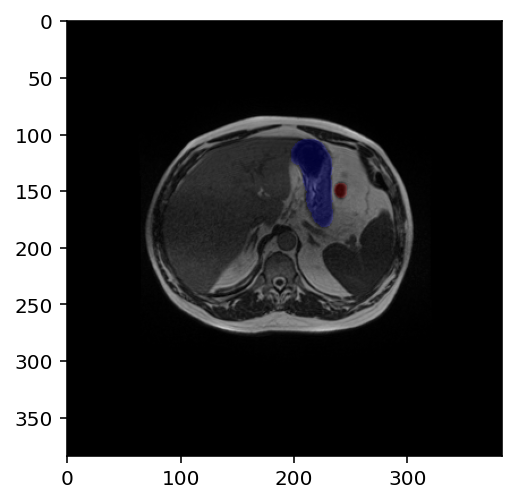

In [139]:
img, mask = ds.__getitem__(75)
plt.imshow(img)
plt.imshow(mask, alpha=0.2)
plt.show();

In [140]:
transform = create_transform(img_size=(384, 384))
ds = Dataset(
    df=df,
    img_size=(384, 384),
    n_img_chanels=1,
    uint8=False,
    sequence=False,
    norm=True,
    shuffle=False,
    seed=42,
    transform=transform,
)

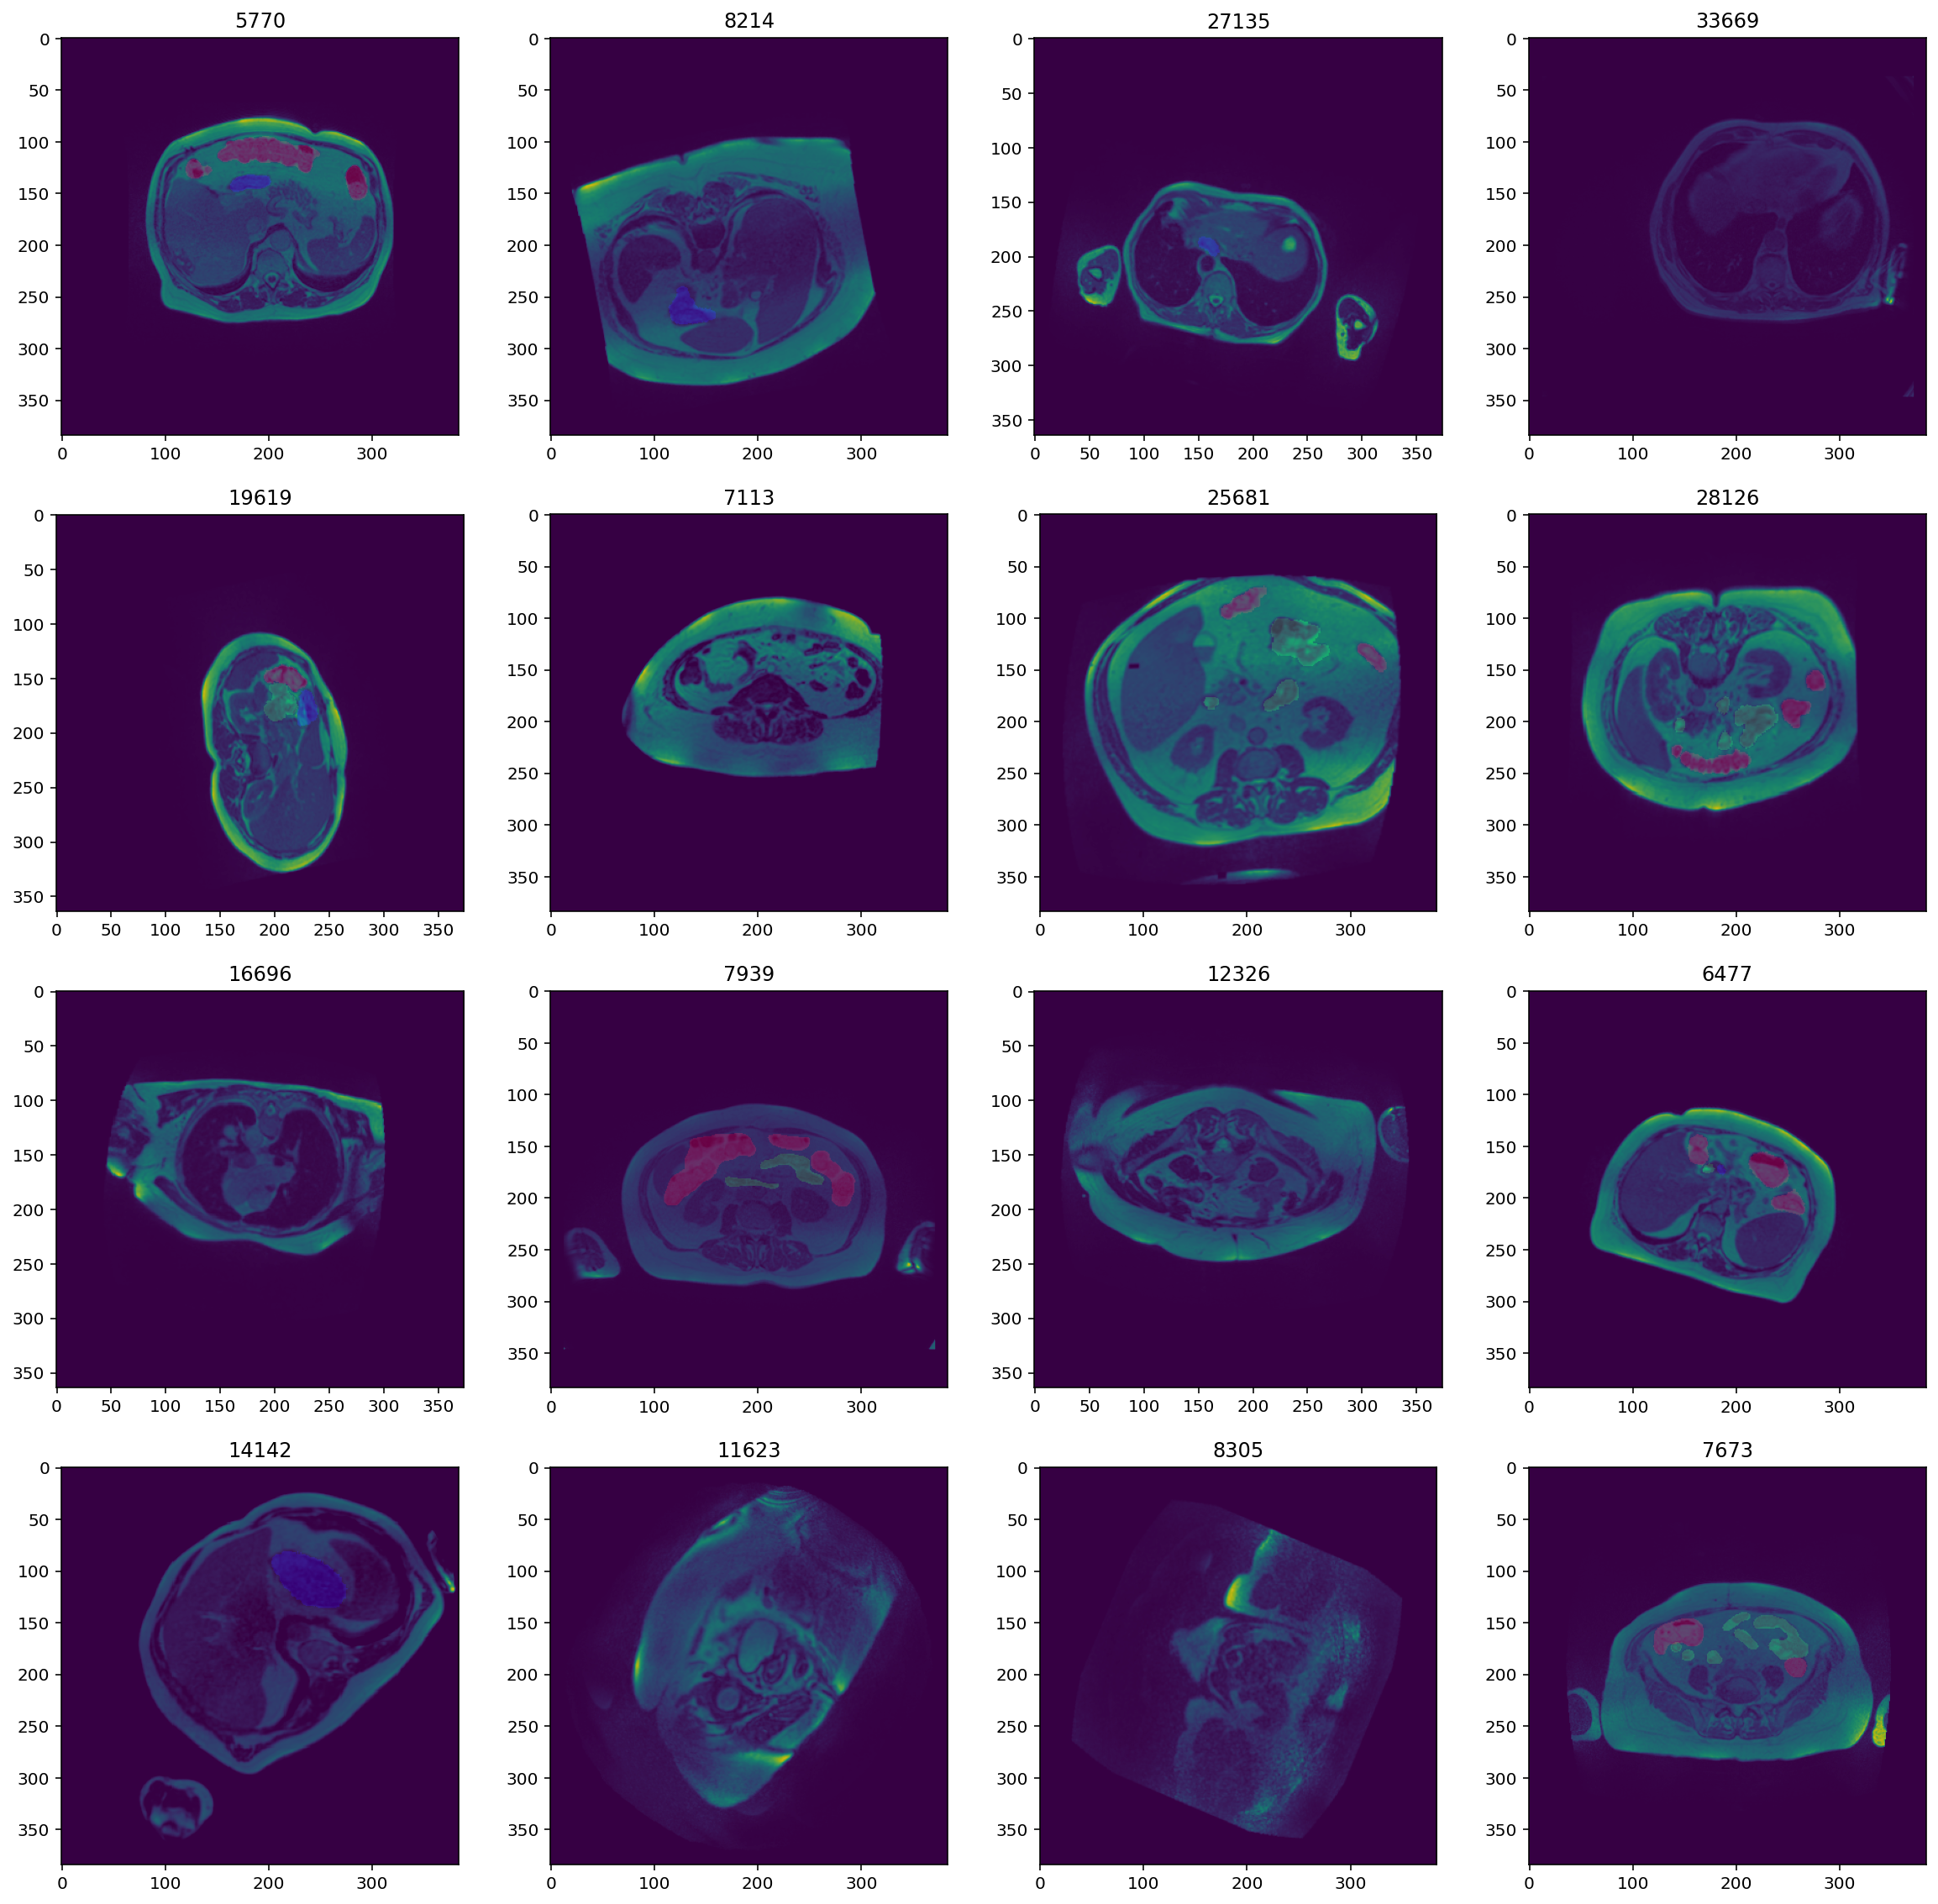

In [141]:
plt.figure(figsize=(20, 20))
for i in range(16):
    ix = df.index[np.random.randint(df.index.shape[0])]
    img, mask = ds.__getitem__(ix)
    plt.subplot(4, 4, i + 1)
    plt.title(str(ix))
    plt.imshow(img)
    plt.imshow(mask, alpha=0.2)
plt.show();

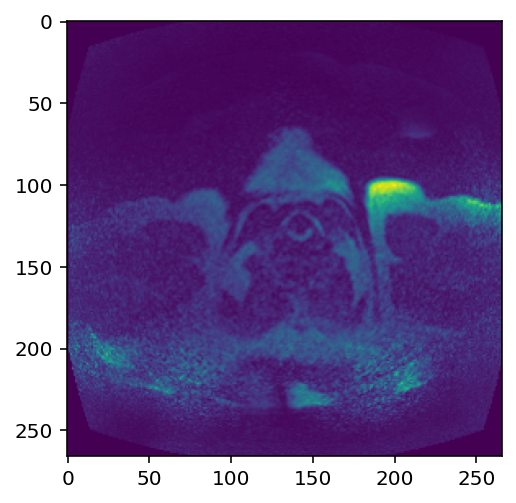

In [145]:
ix = 8305
npy_path = df.loc[ix, 'npy_path']
img_path = df.loc[ix, 'path'] 
img = np.load(npy_path)
plt.imshow(img[:,:,0] / img.max())

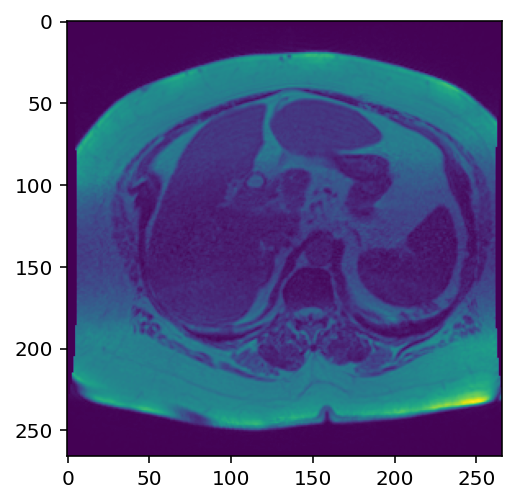

In [143]:
img0 = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
plt.imshow(img0)

In [144]:
np.array_equal(img0, img[:,:,0])

True

In [112]:
transform = create_transform(img_size=(384, 384))
ds = Dataset(
    df=df,
    img_size=(384, 384),
    n_img_chanels=1,
    uint8=False,
    sequence=False,
    norm=True,
    batch_size=32,
    shuffle=False,
    seed=42,
    transform=transform,
)

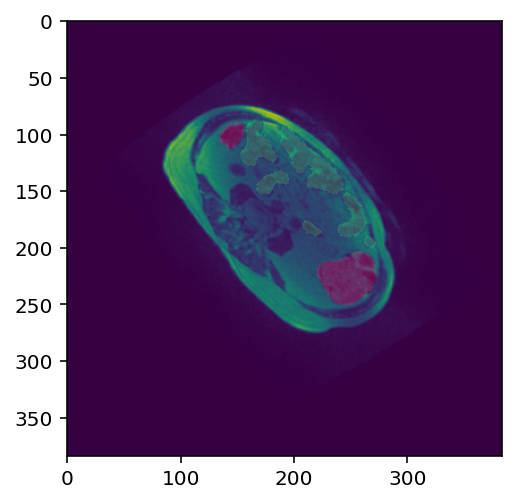

In [112]:
ix = df.index[np.random.randint(df.index.shape[0])]
img, mask = ds.__getitem__(ix)
plt.imshow(img)
plt.imshow(mask, alpha=0.2)
plt.show();

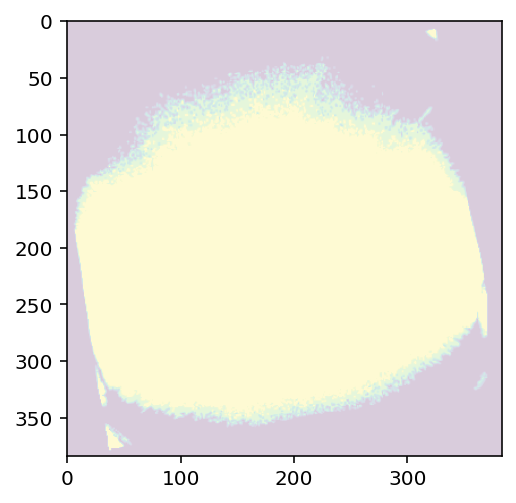

In [96]:
plt.imshow(img, alpha=0.2)